# Benchmarking models at locating spatial expression of cell types with scRNA-seq reference and Visium spatial (mouse brain)

In [1]:
import sys, ast, os
import time
import pickle
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import os
from plotnine import *
import matplotlib.pyplot as plt 
import matplotlib
data_type = 'float32'
#os.environ["THEANO_FLAGS"] = 'device=cuda0,floatX=' + data_type + ',force_device=True'
# /nfs/team283/vk7/software/miniconda3farm5/envs/cellpymc/bin/pip install git+https://github.com/vitkl/cell2location.git
sys.path.insert(1, '/nfs/team205/vk7/sanger_projects/cell2location_dev/')
sys.path.insert(1, '/nfs/team205/vk7/sanger_projects/BayraktarLab/cell2location/')

import cell2location.models as c2l
import cell2location.plt as c2lpl
import cell2location.cluster_averages 
import cell2location
import pymc3 as pm

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
import seaborn as sns

import itertools

# scanpy prints a lot of warnings
import warnings
warnings.filterwarnings('ignore')

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


`THEANO_FLAGS='force_device=True'` forces the package to use GPU. Pay attention to error messages that might indicate theano failed to initalise the GPU.   
Do not forget to change `device=cuda4` to your available GPU id. Use `device=cuda` / `device=cuda0` if you have just one locally or if you are requesting one GPU via HPC cluster job.

### The purpose of the notebook is to benchmark several versions of the model using mouse brain data.

In [2]:
sc_data_folder = '/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_data/mouse_visium_snrna/'
sp_data_folder = '/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/benchmarking/with_tissue_zones/data/'
results_folder = '/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/benchmarking/with_tissue_zones/'
date = '20210131'

In [3]:
## simulation settings
seed = 253286
n_locations = [50, 50] # 50*50 grid
n_experiments = 10

# sparsity and tissue zones
n_tissue_zones = 12
n_uniform = 8

# low and high density cell types
p_high_density = 0.2
mu_low_density = 1.0
mu_high_density = 2.8

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [gene_level_beta_hyp, gene_level_alpha_hyp]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


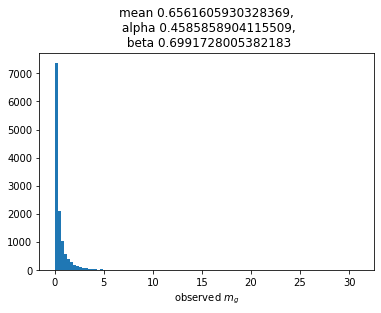

In [4]:
# read a previously trained LocationModel
c2l_results_folder = '/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/mouse_visium_snrna/'
run_name = 'LocationModelLinearDependentWMultiExperiment_59clusters_14968locations_12809genes_n_comb50_mean_var5_inferred_30k'

sp_data_file = f'{c2l_results_folder}{run_name}/sp_with_clusters.h5ad'
adata_vis = anndata.read(sp_data_file)

# put observed gene levels to data frame
gene_level_df = pd.DataFrame(adata_vis.uns['mod']['post_sample_means']['gene_level'],
                          index=adata_vis.uns['mod']['var_names'],
                          columns=['gene_level'])

# use MCMC to find global distribution parameters
import pymc3 as pm

with pm.Model() as model:
    gene_level_alpha_hyp = pm.Gamma('gene_level_alpha_hyp', 1, 1, shape=(1, 1))
    gene_level_beta_hyp = pm.Gamma('gene_level_beta_hyp', 1, 1, shape=(1, 1))
    # global gene levels
    gene_level = pm.Gamma('gene_level', gene_level_alpha_hyp,
                          gene_level_beta_hyp, shape=(gene_level_df.shape[0], 1),
                          observed=gene_level_df.values)
    
    posterior = pm.sample()
    posterior_pred = pm.sample_posterior_predictive(posterior)
    

plt.hist(gene_level_df.values.flatten(), bins=100);
plt.xlabel(r'observed $m_g$')
plt.title(f'mean {gene_level_df.values.mean()},\n alpha {posterior["gene_level_alpha_hyp"].mean()},\n beta {posterior["gene_level_beta_hyp"].mean()}');

In [5]:
# extract 2 selected samples
adata_snrna_raw = anndata.read(f'{sc_data_folder}rawdata/all_cells_20200625.h5ad')
adata_snrna_raw = adata_snrna_raw[adata_snrna_raw.obs['sample'].isin(['5705STDY8058280', '5705STDY8058281']), :]

## Cell type annotations
labels = pd.read_csv(f'{sc_data_folder}snRNA_annotation_astro_subtypes_refined59_20200823.csv', index_col=0)
labels = labels.reindex(index=adata_snrna_raw.obs_names)
adata_snrna_raw.obs[labels.columns] = labels
adata_snrna_raw = adata_snrna_raw[~adata_snrna_raw.obs['annotation_1'].isna(), :]
ct_sel = adata_snrna_raw.obs['annotation_1'].value_counts() > 40
ct_sel = list(np.array(ct_sel.index)[ct_sel.values])
adata_snrna_raw = adata_snrna_raw[adata_snrna_raw.obs['annotation_1'].isin(ct_sel), :]

adata_snrna_raw.write(f'{sc_data_folder}rawdata/5705STDY8058280_5705STDY8058281_{date}.h5ad')

shared_names = adata_snrna_raw.obs_names[adata_snrna_raw.obs_names.isin(labels.index)]
labels = labels.loc[shared_names,]
labels.to_csv(f'/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/mouse_visium_snrna/snRNA_annotation_subclusters_{date}_samples2.csv')

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
... storing 'annotation_1' as categorical


In [6]:
adata_snrna_raw.obs['annotation_1'].value_counts()

Oligo_2           4021
Ext_L23            715
Ext_Thal_1         546
Inh_4              537
Ext_L25            520
Ext_L56            514
Micro              505
Ext_Pir            489
Inh_1              477
Ext_Hpc_DG2        475
Ext_L5_1           432
Unk_1              375
OPC_1              372
Inh_Pvalb          362
Ext_Hpc_CA1        341
Inh_Meis2_3        323
Ext_Thal_2         316
Ext_Amy_2          313
Inh_3              288
Inh_Sst            250
Inh_6              244
Inh_Meis2_2        242
Ext_L6             240
Inh_Vip            215
Astro_CTX          208
Ext_Hpc_DG1        202
Inh_Meis2_1        181
Astro_HYPO         179
Oligo_1            179
Astro_AMY_CTX      168
Inh_2              151
Astro_THAL_med     149
Inh_Lamp5          135
Astro_AMY          125
Astro_THAL_lat     123
OPC_2              120
Ext_Hpc_CA3        120
Ext_L6B            119
LowQ_2             119
Ext_Amy_1          106
Ext_L5_2           105
Nb_1               105
Astro_HPC          101
Ext_ClauPyr

In [7]:
np.random.seed(seed)
## Generate generation - training split (to reflect that spatial data does not have exactly the same cells)
from sklearn.model_selection import train_test_split
idx = np.arange(len(adata_snrna_raw))
train_idx, val_idx = train_test_split(idx, train_size=0.5,
                                      shuffle=True, stratify=adata_snrna_raw.obs['annotation_1'])

adata_snrna_raw[train_idx].write(f'{sp_data_folder}generation_5705STDY8058280_5705STDY8058281_{date}.h5ad')
adata_snrna_raw[val_idx].write(f'{sp_data_folder}training_5705STDY8058280_5705STDY8058281_{date}.h5ad')

adata_snrna_raw[train_idx].obs['annotation_1'].value_counts(), adata_snrna_raw[train_idx].obs['annotation_1'].value_counts().shape

(Oligo_2           2010
 Ext_L23            357
 Ext_Thal_1         273
 Inh_4              268
 Ext_L25            260
 Ext_L56            257
 Micro              252
 Ext_Pir            244
 Inh_1              238
 Ext_Hpc_DG2        237
 Ext_L5_1           216
 Unk_1              187
 OPC_1              186
 Inh_Pvalb          181
 Ext_Hpc_CA1        170
 Inh_Meis2_3        161
 Ext_Thal_2         158
 Ext_Amy_2          156
 Inh_3              144
 Inh_Sst            125
 Inh_6              122
 Inh_Meis2_2        121
 Ext_L6             120
 Inh_Vip            107
 Astro_CTX          104
 Ext_Hpc_DG1        101
 Inh_Meis2_1         90
 Astro_HYPO          90
 Oligo_1             90
 Astro_AMY_CTX       84
 Inh_2               76
 Astro_THAL_med      75
 Inh_Lamp5           68
 Astro_AMY           63
 Astro_THAL_lat      62
 OPC_2               60
 Ext_Hpc_CA3         60
 Ext_L6B             60
 LowQ_2              60
 Ext_L5_2            53
 Ext_Amy_1           53
 Nb_1           

In [8]:
## simulation settings
np.random.seed(seed)

## generate per cell type simulation attributes
n_cell_types = adata_snrna_raw[train_idx].obs['annotation_1'].value_counts().shape[0]
n_sparse = n_cell_types - n_uniform
n_zones_per_cell_type = np.random.binomial(n_tissue_zones, 0.02, size=n_sparse)+1
experiment_id = np.repeat(np.arange(n_experiments), np.prod(n_locations))
cell_types = np.array(adata_snrna_raw[train_idx].obs['annotation_1'].unique())
uniform_cell_types = np.random.choice(cell_types, n_uniform, replace=False)
sparse_cell_types = cell_types[~np.isin(cell_types, uniform_cell_types)]

# generate matrix of which cell types are in which zones
cell_types2zones = pd.DataFrame(0, index=cell_types, 
                                columns=[f'tissue_zone_{i}' for i in range(n_tissue_zones)] \
                                + [f'uniform_{i}' for i in range(n_uniform)])
for i, n in enumerate(n_zones_per_cell_type):
    pos = np.random.randint(n_tissue_zones, size=n)
    cell_types2zones.iloc[i,pos] = 1
    
# and which uniform cell types belong to which uniform pattern
for i in range(n_uniform):
    cell_types2zones.iloc[n_sparse+i, n_tissue_zones+i] = 1
    
cell_types2zones.sum(), cell_types2zones.sum(1)

(tissue_zone_0     3
 tissue_zone_1     2
 tissue_zone_2     4
 tissue_zone_3     2
 tissue_zone_4     6
 tissue_zone_5     3
 tissue_zone_6     6
 tissue_zone_7     2
 tissue_zone_8     8
 tissue_zone_9     5
 tissue_zone_10    6
 tissue_zone_11    4
 uniform_0         1
 uniform_1         1
 uniform_2         1
 uniform_3         1
 uniform_4         1
 uniform_5         1
 uniform_6         1
 uniform_7         1
 dtype: int64,
 Inh_3             1
 Ext_Pir           2
 Oligo_2           1
 Astro_HYPO        2
 Ext_L25           1
 Astro_THAL_lat    2
 Ext_L5_1          1
 Ext_L23           1
 Micro             1
 Ext_Thal_1        1
 Ext_Hpc_CA1       1
 Inh_Meis2_3       1
 Inh_4             1
 OPC_1             1
 Oligo_1           1
 Ext_Hpc_CA3       1
 Astro_CTX         1
 Astro_THAL_med    1
 Inh_Vip           1
 Ext_Amy_2         1
 Astro_AMY_CTX     1
 Unk_1             1
 Inh_Sst           1
 Inh_Meis2_2       2
 Ext_Hpc_DG2       2
 Ext_Hpc_DG1       1
 Inh_1             

In [9]:
np.random.seed(seed)
# Assign cell types to either high or low density, balanced by uniform / tissue zone
high_density_cell_types = list(np.random.choice(uniform_cell_types, 
                                                int(np.round(n_uniform * p_high_density)), 
                                                replace=False))
for z, n in cell_types2zones.sum().items():
    
    ct = list(np.random.choice(cell_types2zones.index[cell_types2zones[z] > 0], 
                                                int(np.round(n * p_high_density)), 
                                                replace=False))
    print(ct)
    high_density_cell_types = high_density_cell_types + ct
    
low_density_cell_types = cell_types[~np.isin(cell_types, high_density_cell_types)]
    
# what proportion of cells are uniform?
len(high_density_cell_types) / len(cell_types)

['Ext_Thal_2']
[]
['Astro_THAL_med']
[]
['Ext_Amy_2']
['Inh_Meis2_3']
['Inh_Vip']
[]
['Ext_L6B', 'Ext_Pir']
['Astro_THAL_lat']
['Inh_Meis2_4']
['Ext_Hpc_CA1']
[]
[]
[]
[]
[]
[]
[]
[]


0.24489795918367346

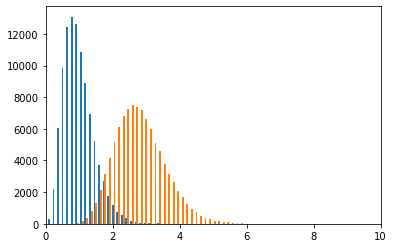

In [10]:
np.random.seed(seed)
#Generate average abundance for low and high density cell types
mean_var_ratio = 5
plt.hist([np.random.gamma(mu_low_density * mean_var_ratio, 1/mean_var_ratio, size=int(1e5)),
          np.random.gamma(mu_high_density * mean_var_ratio, 1/mean_var_ratio, size=int(1e5))], bins=50);
plt.xlim(0, 10);

cell_types2zones.loc[low_density_cell_types] = cell_types2zones.loc[low_density_cell_types] \
 * np.random.gamma(mu_low_density * mean_var_ratio, 
                   1/mean_var_ratio, 
                   size=(len(low_density_cell_types), 1))

cell_types2zones.loc[high_density_cell_types] = cell_types2zones.loc[high_density_cell_types] \
 * np.random.gamma(mu_high_density * mean_var_ratio, 
                   1/mean_var_ratio, 
                   size=(len(high_density_cell_types), 1))

In [11]:
cell_types2zones

,tissue_zone_0,tissue_zone_1,tissue_zone_2,tissue_zone_3,tissue_zone_4,tissue_zone_5,tissue_zone_6,tissue_zone_7,tissue_zone_8,tissue_zone_9,tissue_zone_10,tissue_zone_11,uniform_0,uniform_1,uniform_2,uniform_3,uniform_4,uniform_5,uniform_6,uniform_7
Inh_3,0.000000,0.000000,0.934032,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Ext_Pir,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.584911,0.000000,3.584911,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Oligo_2,0.000000,0.661809,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Astro_HYPO,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.759034,0.000000,0.759034,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Ext_L25,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.363876,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Astro_THAL_lat,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.689548,4.689548,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Ext_L5_1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.773184,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Ext_L23,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.725949,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Micro,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.672055,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Ext_Thal_1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.988135,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


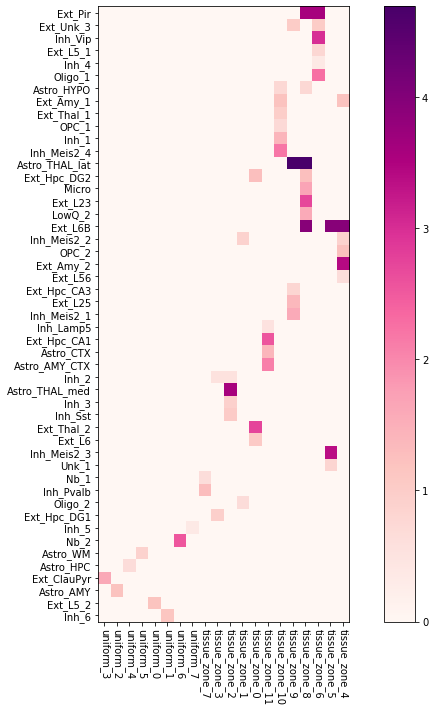

In [12]:
from cell2location.plt.plot_heatmap import clustermap
clustermap(cell_types2zones, figure_size=[10, 10])

## Generate spatial patterns (uniform_i & per tissue_zone_i)

In [13]:
def kernel(X1, X2, l=1.0, eta=1.0):
    '''
    Isotropic squared exponential kernel. Computes 
    a covariance matrix from points in X1 and X2.
    
    Args:
        X1: Array of m points (m x d).
        X2: Array of n points (n x d).

    Returns:
        Covariance matrix (m x n).
    '''
    sqdist = np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)
    return eta**2 * np.exp(-0.5 / l**2 * sqdist)
    
def generate_grid(
              n=[50, 50] #spatial dimensions 
):
    n1, n2 = n 
    x1 = np.linspace(0, 100, n1)[:,None] #saptial dimensions 
    x2 = np.linspace(0, 100, n2)[:,None] #saptial dimensions 

    # make cartesian grid out of each dimension x1 and x2
    return pm.math.cartesian(x1[:,None], x2[:,None]), x1, x2

def random_GP(X, x1=1, x2=1, #coordinates
              n_variables = 5, #zones
              eta_true = 5, #variance, defines overlapping
              l1_true=[8, 10, 15], #bw parameter
              l2_true=[8, 10, 15]
             ):

    #cov1, cov2 = kernel(x1, x1, l=l1_true), kernel(x2, x2, l=l2_true)
    K = [np.kron(kernel(x1, x1, l=l1_true[i], eta=eta_true), 
                 kernel(x2, x2, l=l2_true[i], eta=eta_true)) 
         for i in range(n_variables)]

    gaus_true = np.stack([np.random.multivariate_normal(np.zeros(X.shape[0]), 
                                                        2*K[i]) 
                          for i in range(n_variables)]).T #samples from GP
    N_true = (np.exp(gaus_true).T / np.exp(gaus_true).sum(axis=1)).T #softmax transform 
    return N_true


def plot_spatial(values, n=[50,50], nrows=5, names=['cell type'],
                 vmin=0, vmax=1):
    
    n_cell_types = values.shape[1]
    n1, n2 = n 
    ncols = np.ceil((n_cell_types+1) / nrows)
    for ct in range(n_cell_types):
        plt.subplot(nrows, ncols, ct+1)
        plt.imshow(values[:,ct].reshape(n1,n2).T, 
                   cmap=plt.cm.get_cmap('magma'),
                   vmin=vmin, vmax=vmax
                  )
        plt.colorbar()
        if len(names) > 1:
            plt.title(names[ct])
        else:
            plt.title(f'{names[0]} {ct+1}')

    plt.subplot(nrows, ncols, n_cell_types+1) 
    plt.imshow(values.sum(axis=1).reshape(n1,n2).T, 
               cmap=plt.cm.get_cmap('Greys'))
    plt.colorbar()
    plt.title('total')

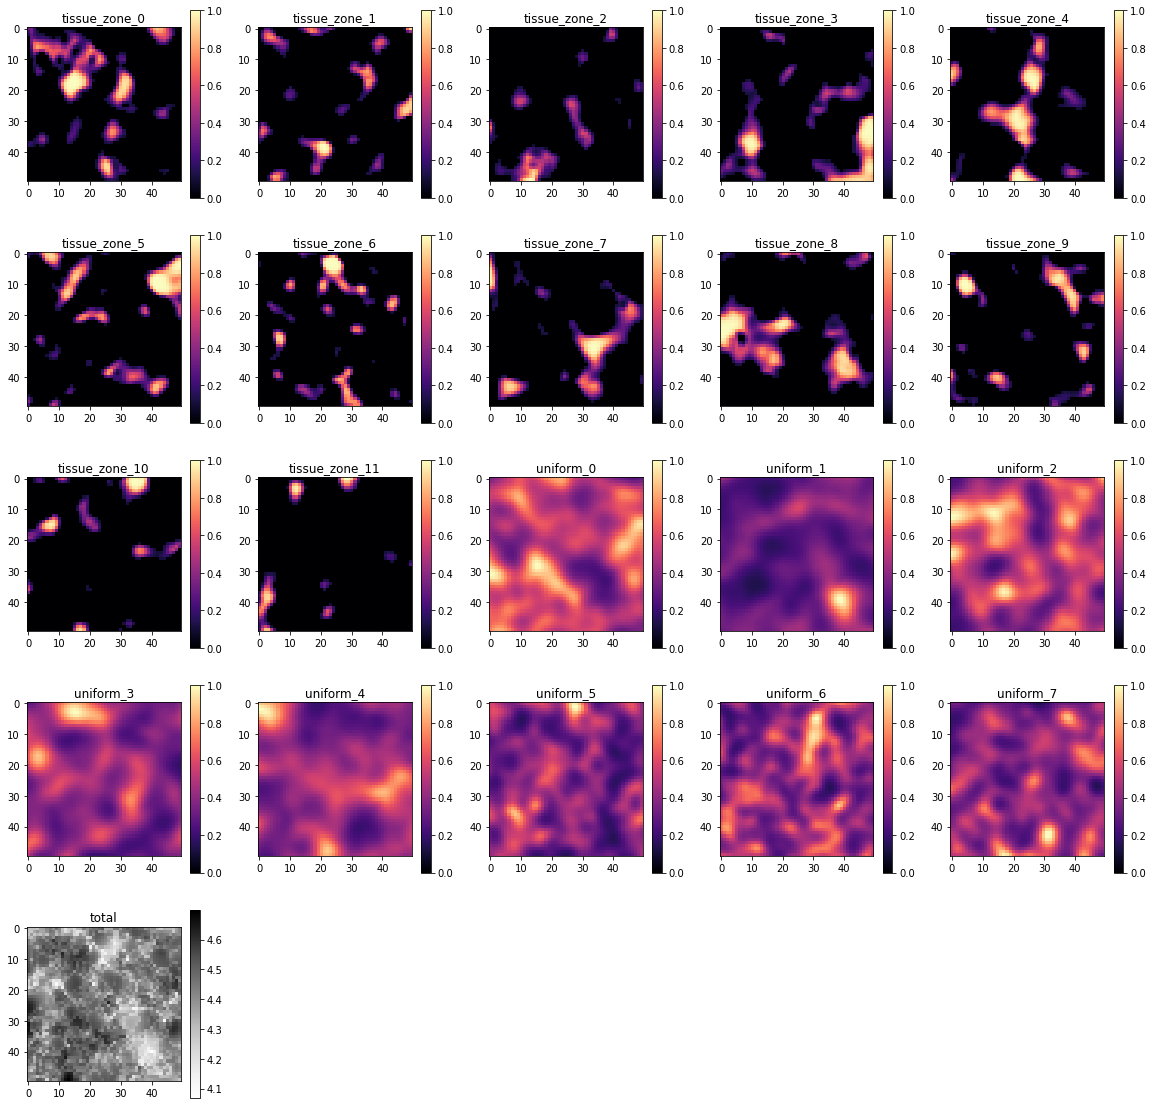

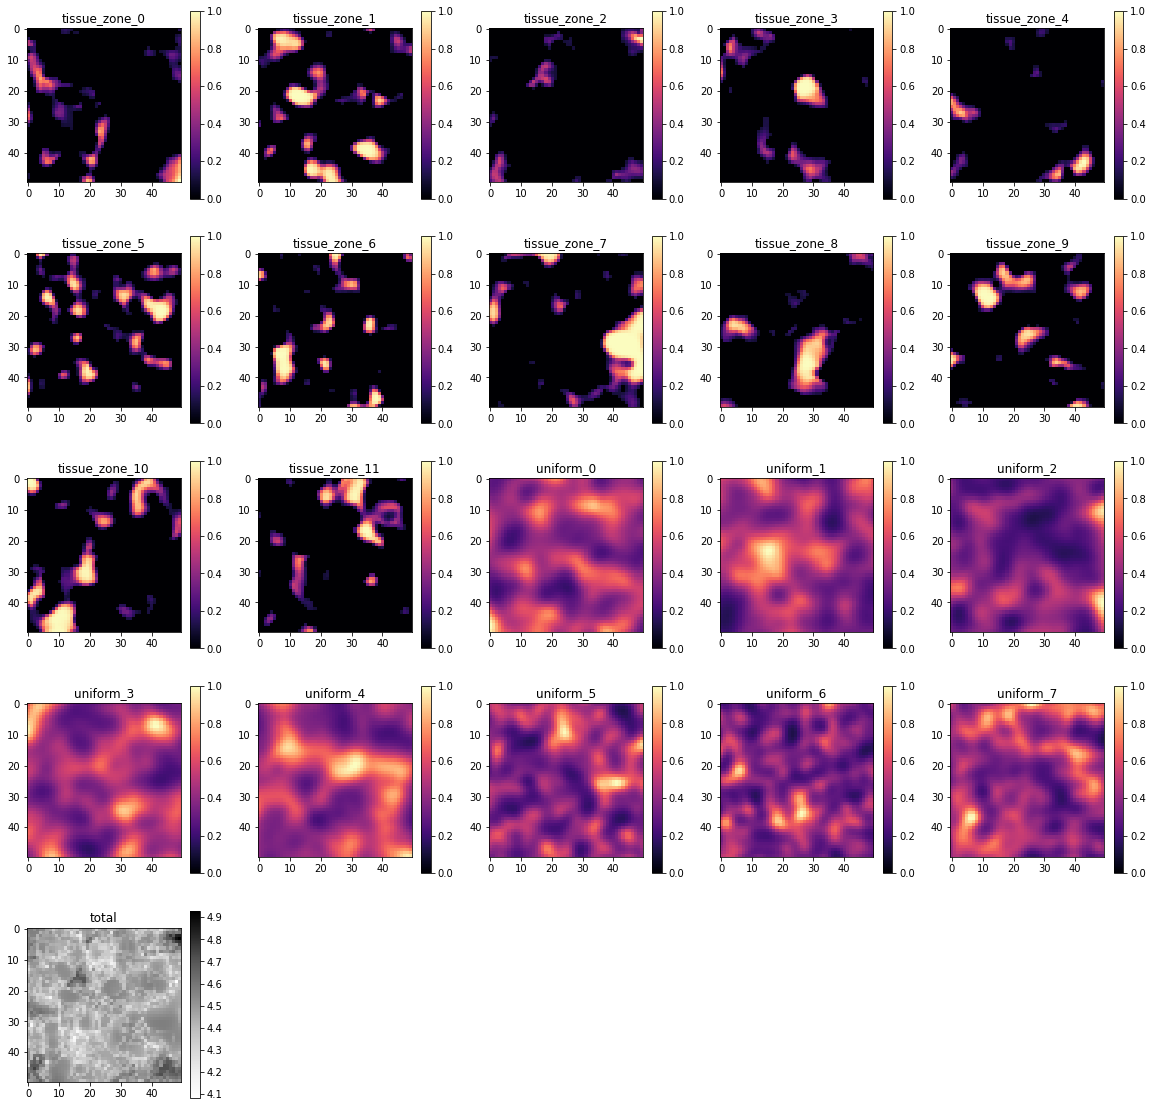

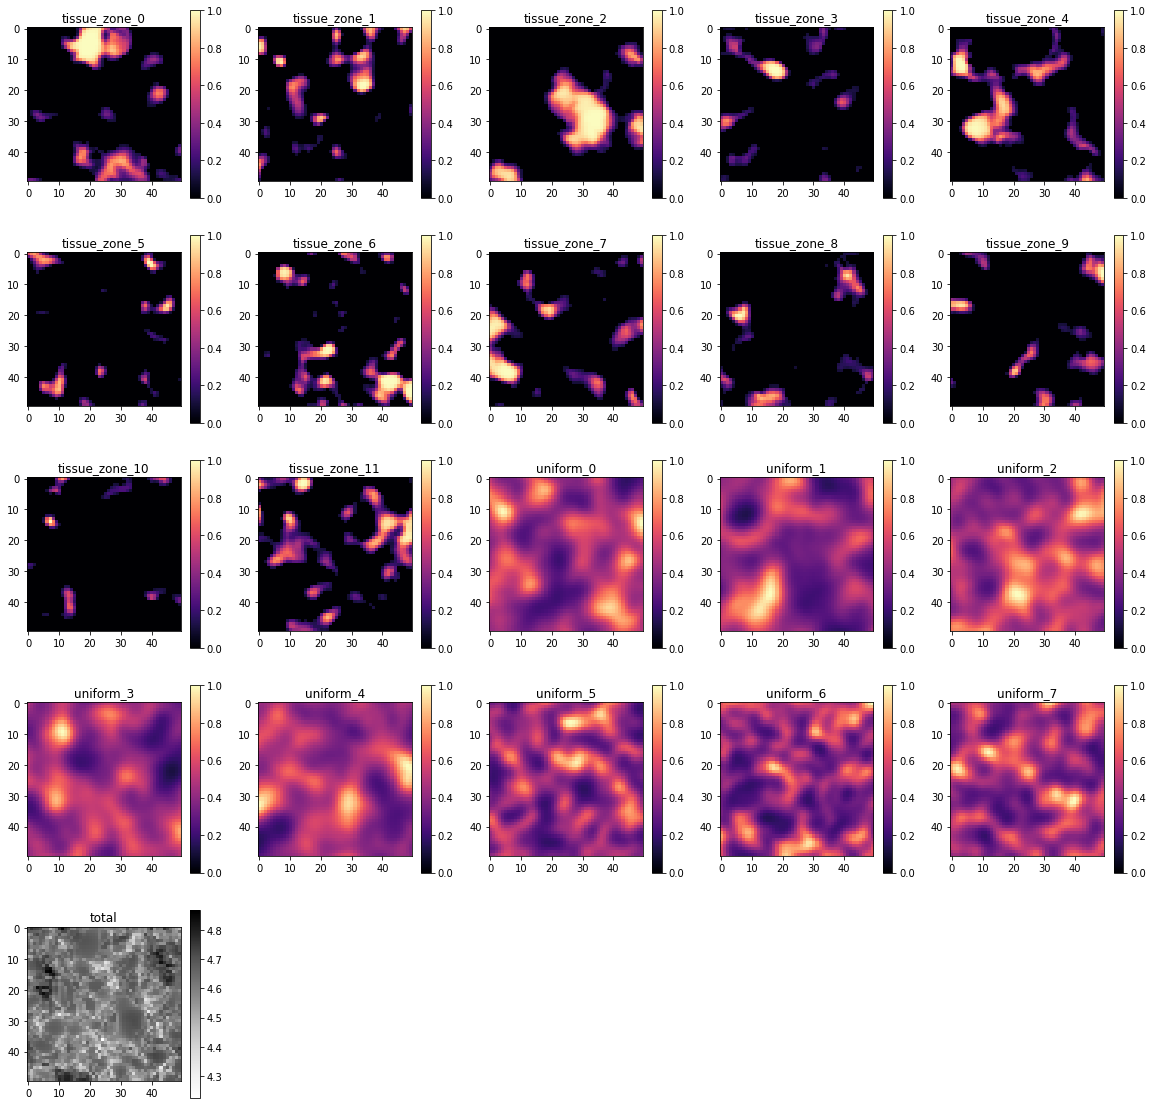

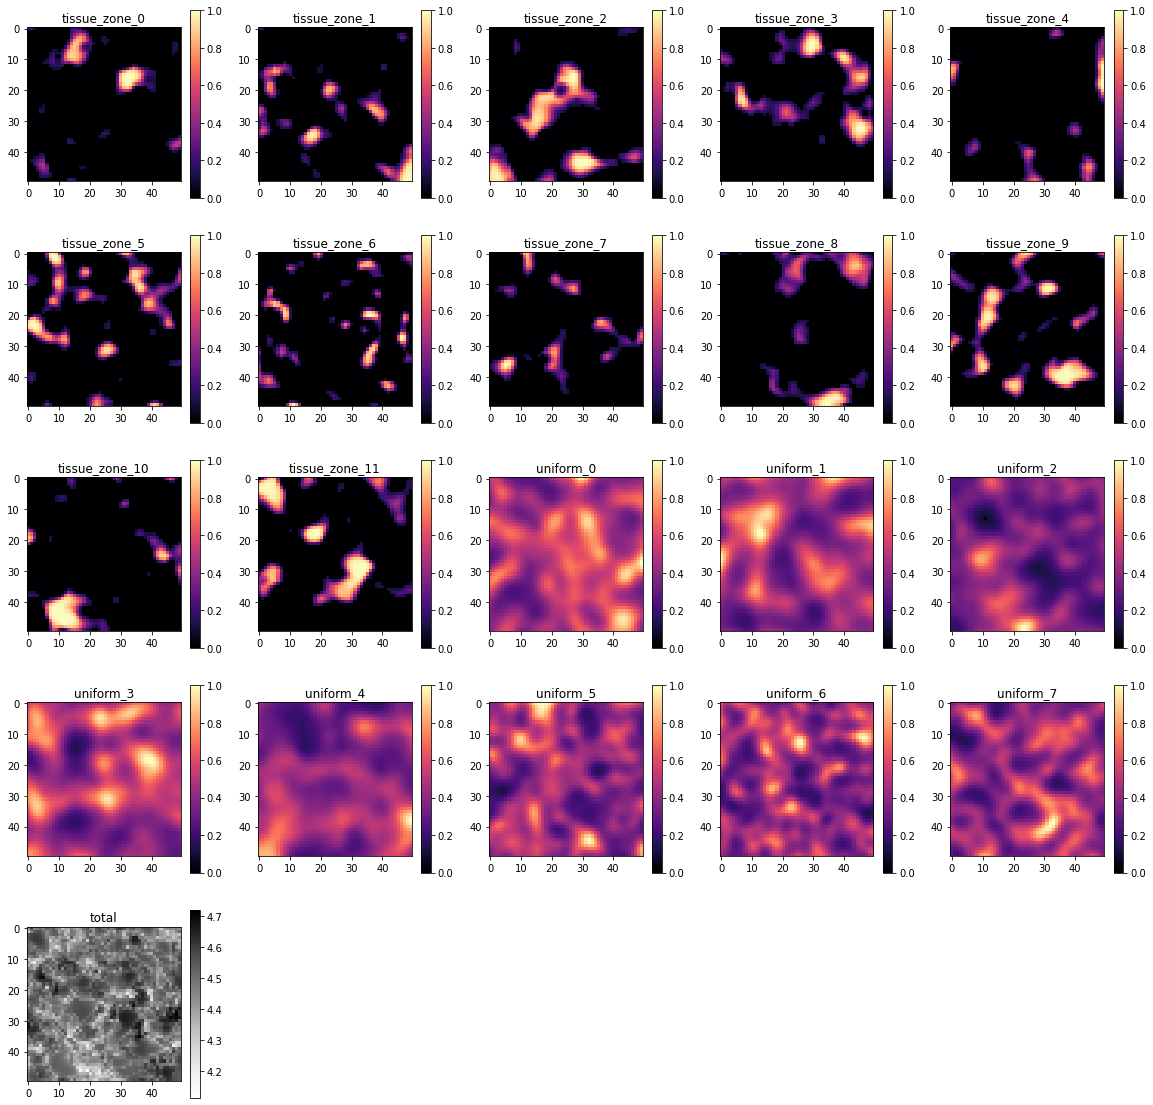

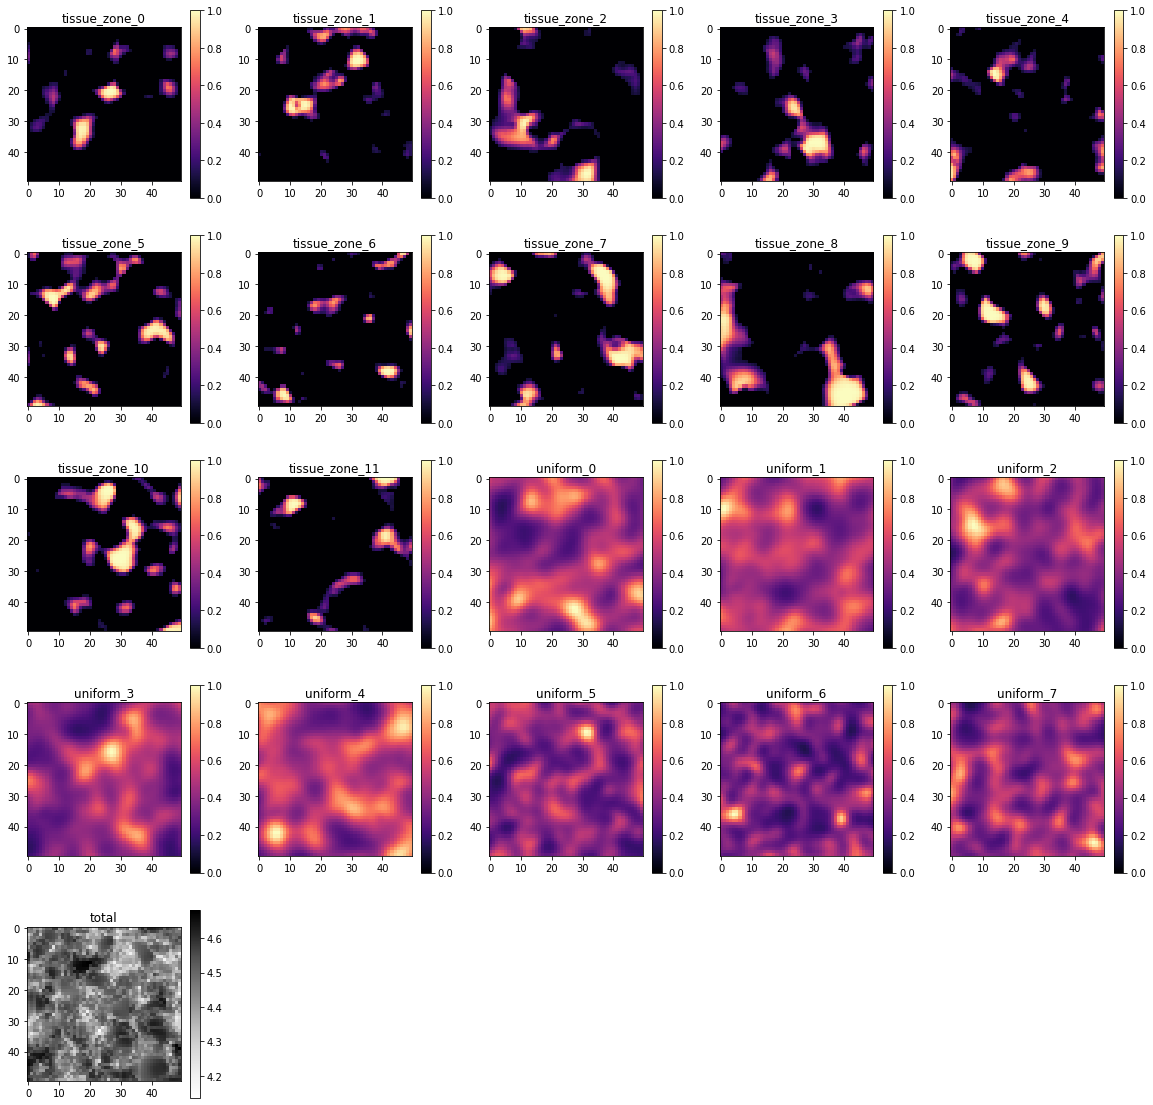

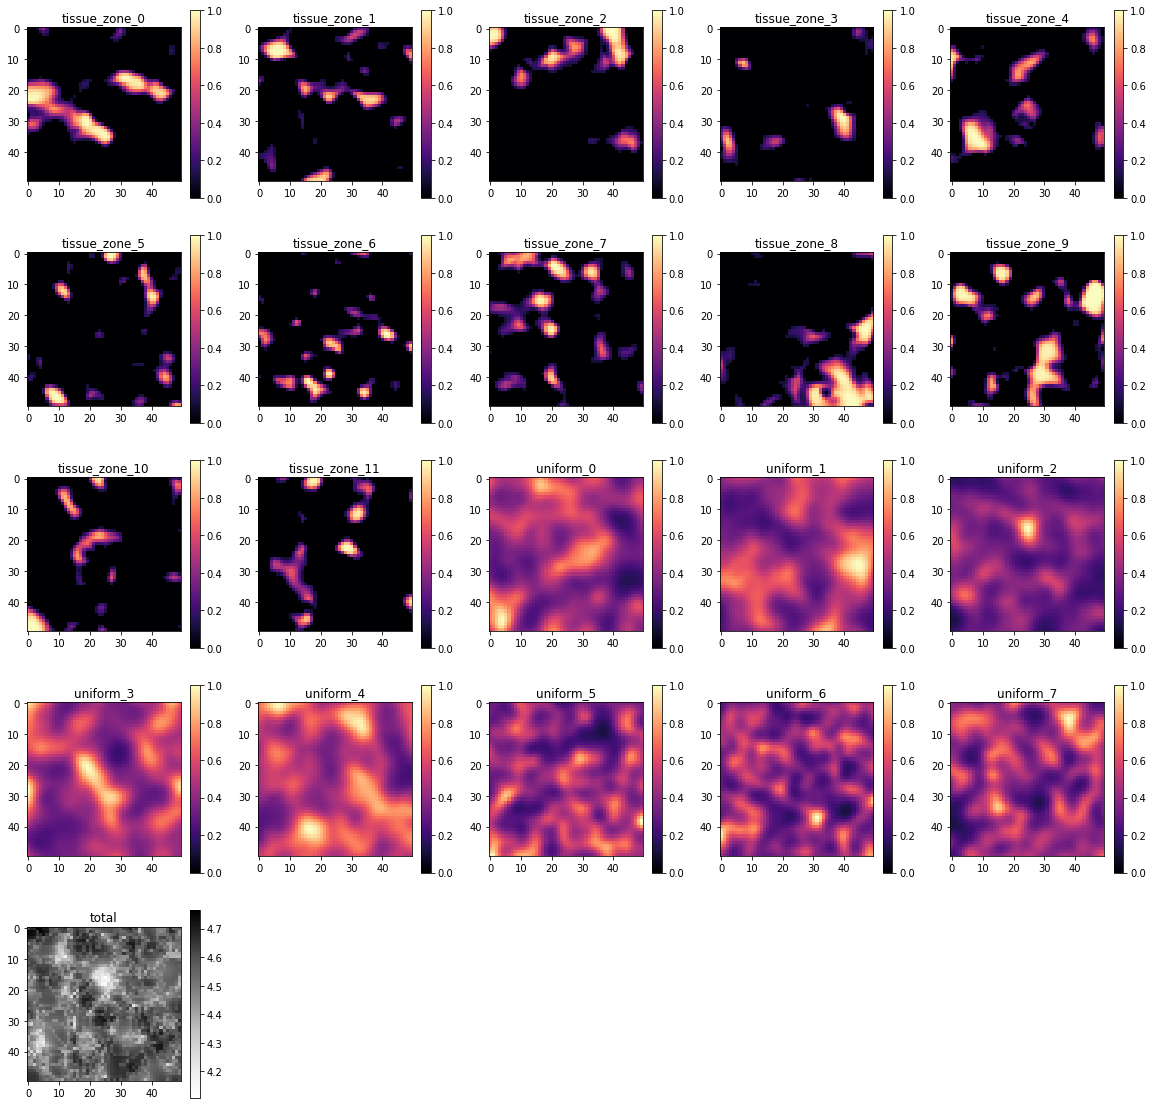

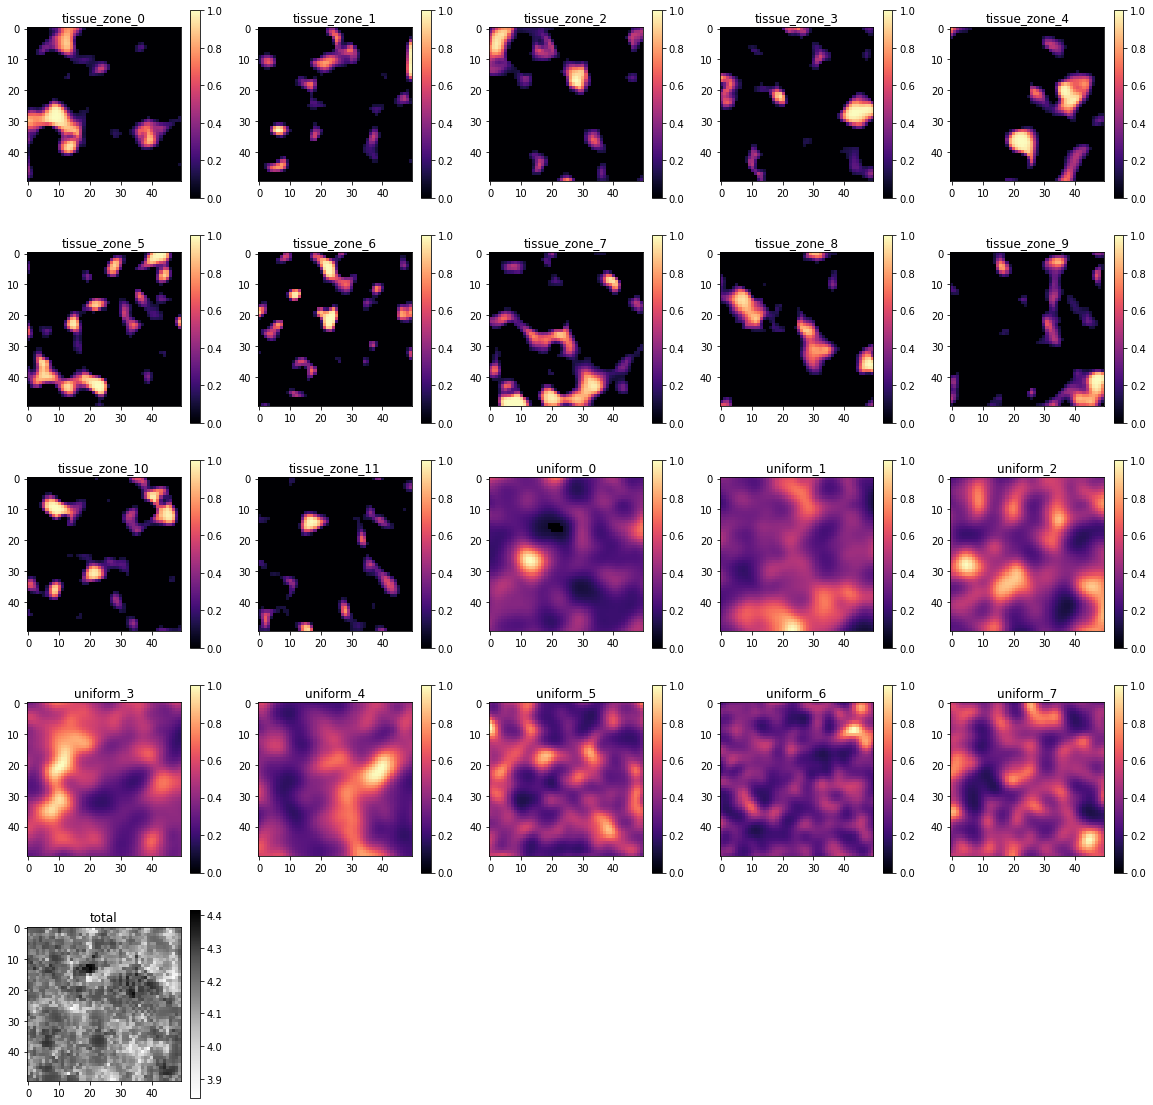

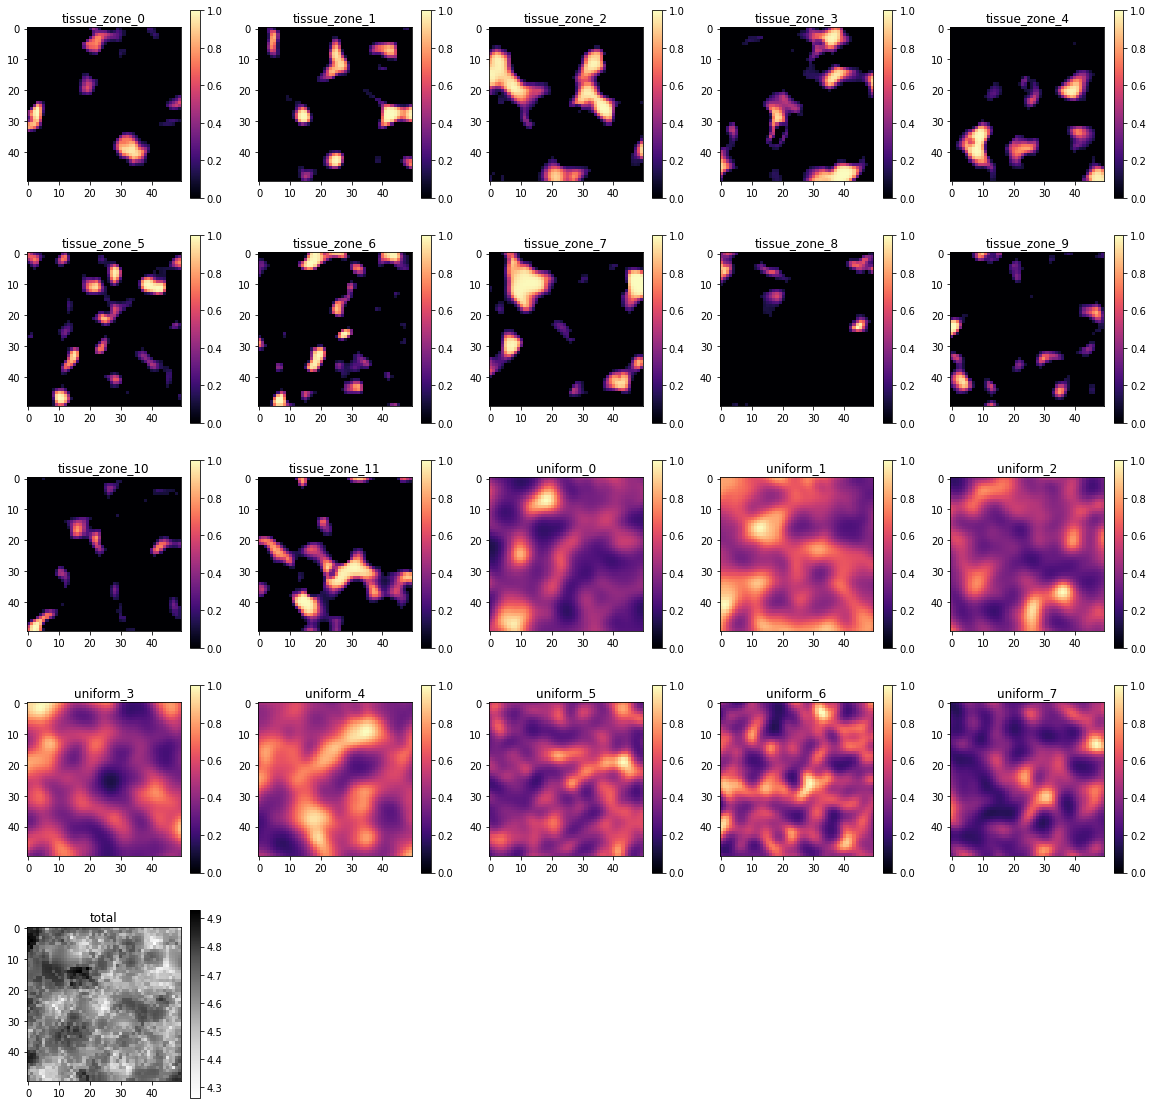

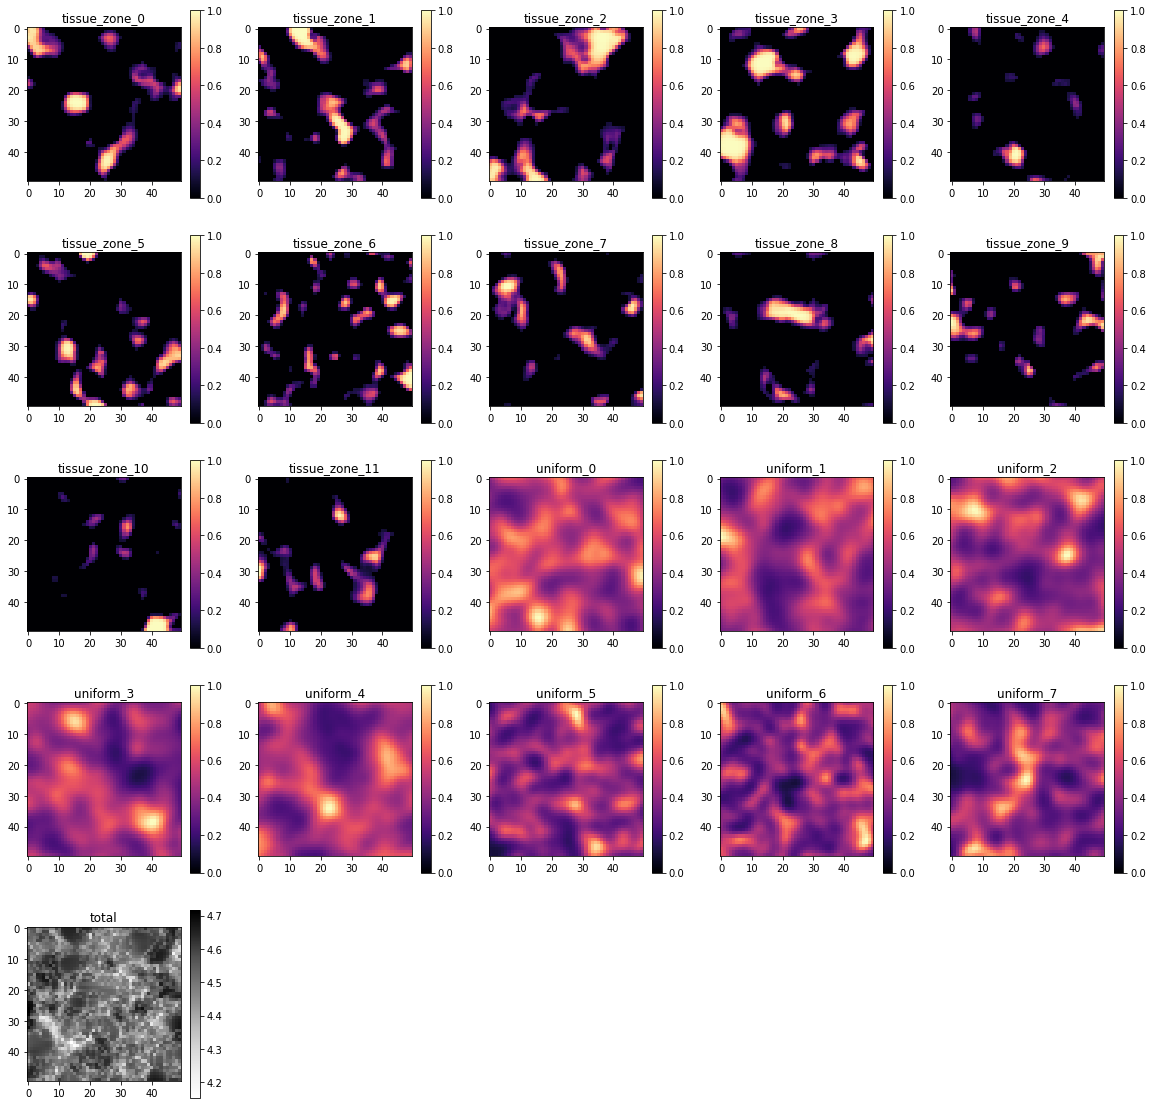

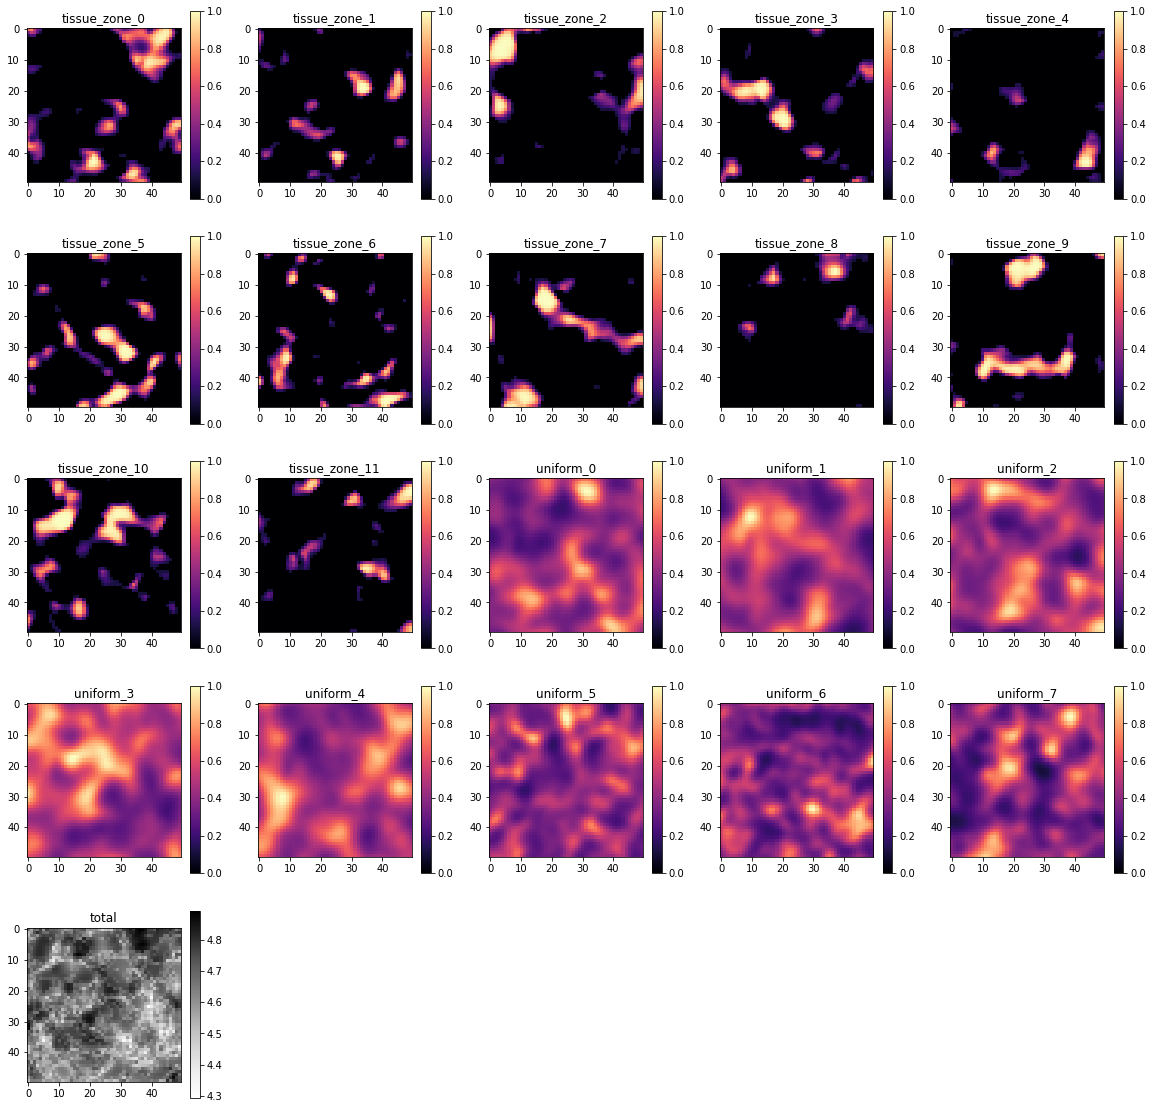

In [14]:
np.random.seed(seed)
# Sample bw parameter
mean_var_ratio = 1.2
mean = 8
tissue_zones_l1_true = np.random.gamma(mean * mean_var_ratio, 1 / mean_var_ratio, 
                                       size=(n_tissue_zones))
uniform_cell_types_l1_true = np.random.gamma(mean * mean_var_ratio, 1 / mean_var_ratio, 
                                             size=(len(uniform_cell_types)))
def sample_GP(locations, x1, x2):
    # Sample abundances with GP
    sparse_abundances = random_GP(X=locations, x1=x1, x2=x2, n_variables=n_tissue_zones, 
                                                    eta_true=1.5,
                                                    l1_true=tissue_zones_l1_true,
                                                    l2_true=tissue_zones_l1_true)
    sparse_abundances = sparse_abundances / sparse_abundances.max(0)
    sparse_abundances[sparse_abundances < 0.1] = 0

    uniform_abundances = random_GP(X=locations, x1=x1, x2=x2, n_variables=len(uniform_cell_types), 
                                                      eta_true=0.5,
                                                    l1_true=uniform_cell_types_l1_true,
                                                    l2_true=uniform_cell_types_l1_true)
    uniform_abundances = uniform_abundances / uniform_abundances.max(0)
    uniform_abundances[uniform_abundances < 0.1] = 0

    abundances = np.concatenate([sparse_abundances, uniform_abundances], axis=1)
    return pd.DataFrame(abundances, 
                                 index=[f'location_{i}' for i in range(abundances.shape[0])],
                                 columns=cell_types2zones.columns
                                )

locations_1, x1, x2 = generate_grid(n=n_locations)
locations = np.concatenate([locations_1 for _ in range(n_experiments)], axis=0)

abundances_df = pd.DataFrame()

for e in range(n_experiments):
    
    abundances_df_1 = sample_GP(locations_1, x1, x2)
    abundances_df_1.index = [f'exper{e}_{l}' for l in abundances_df_1.index]
    abundances_df = pd.concat((abundances_df, abundances_df_1), axis=0)
    
    plt.figure(figsize=(3*5+5,3*5+5))
    plot_spatial(abundances_df_1.values, n=n_locations, nrows=5, names=abundances_df.columns)
    plt.show()

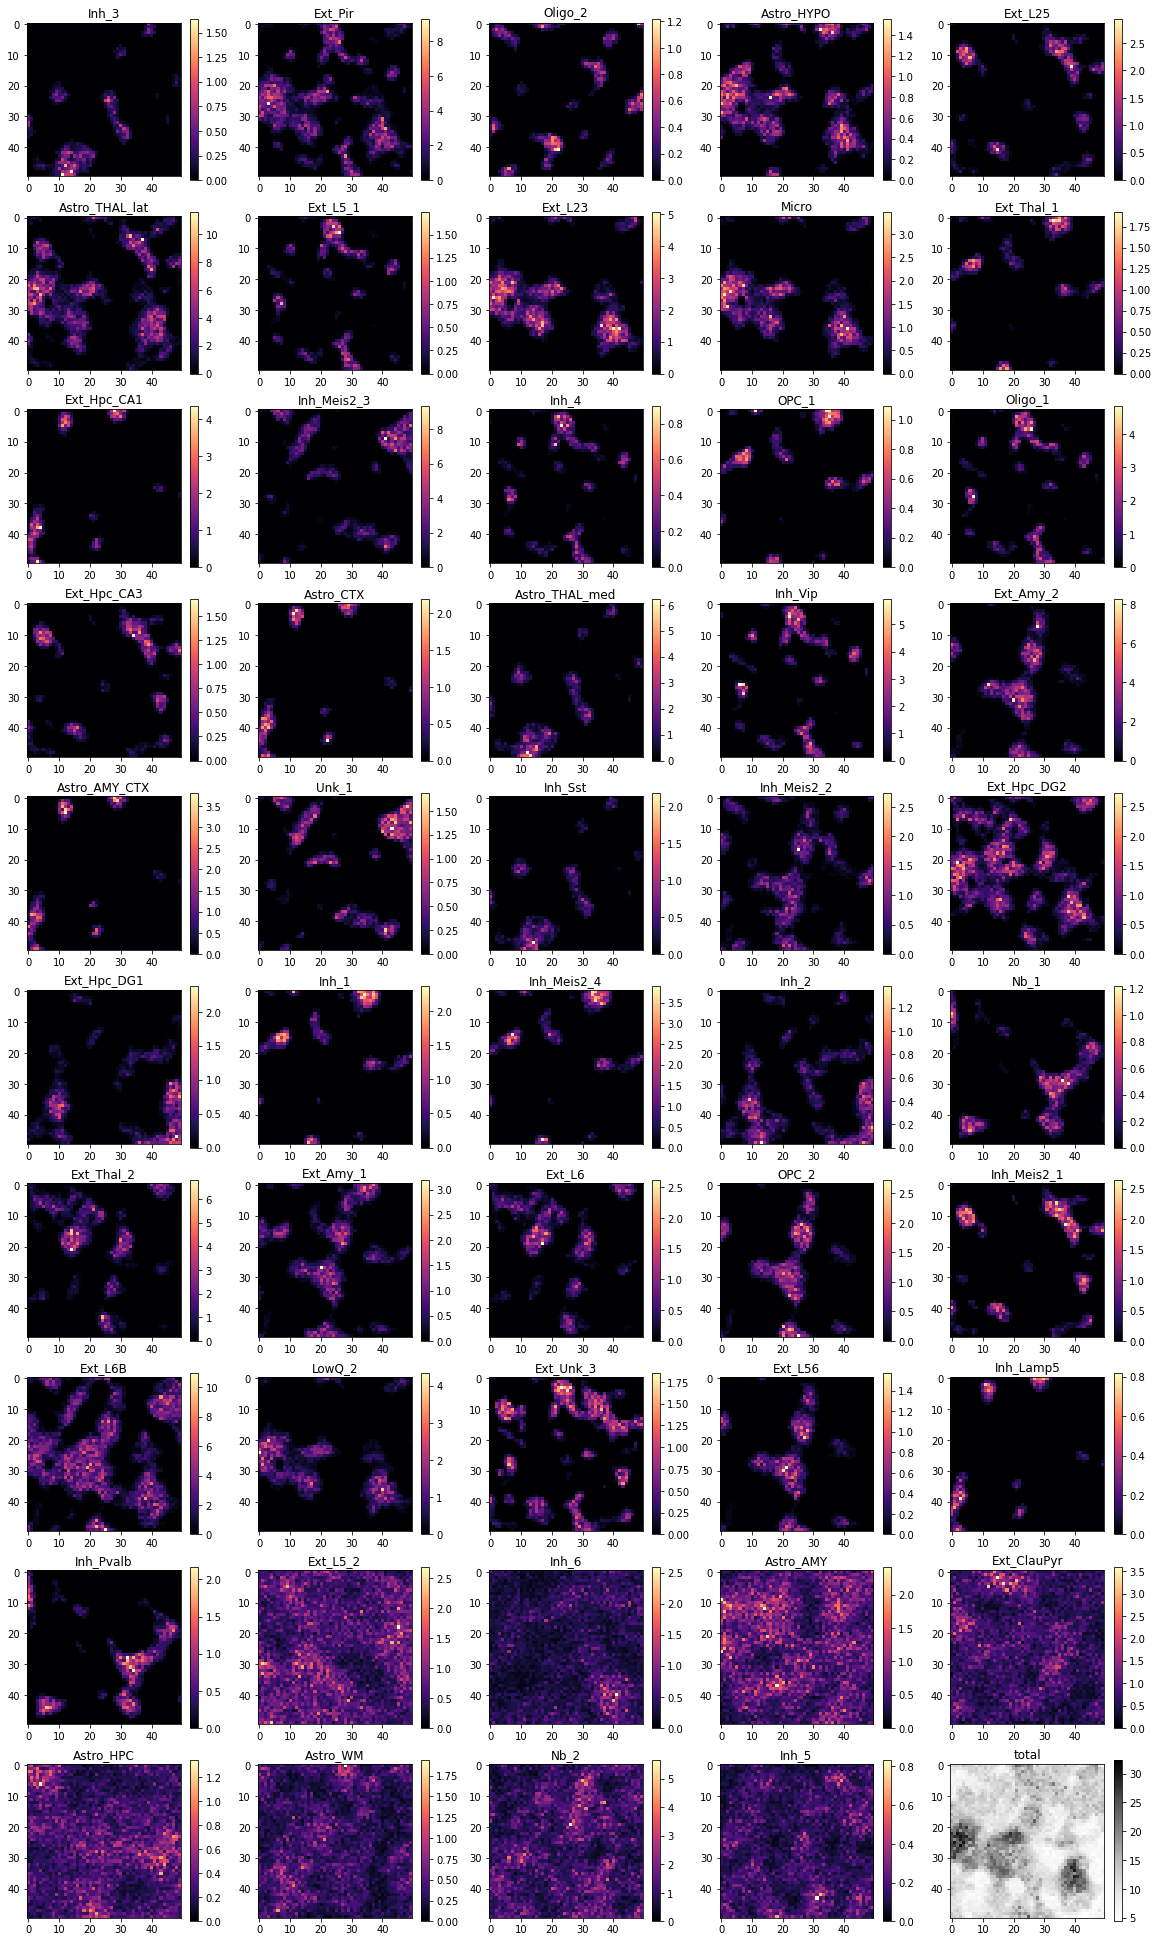

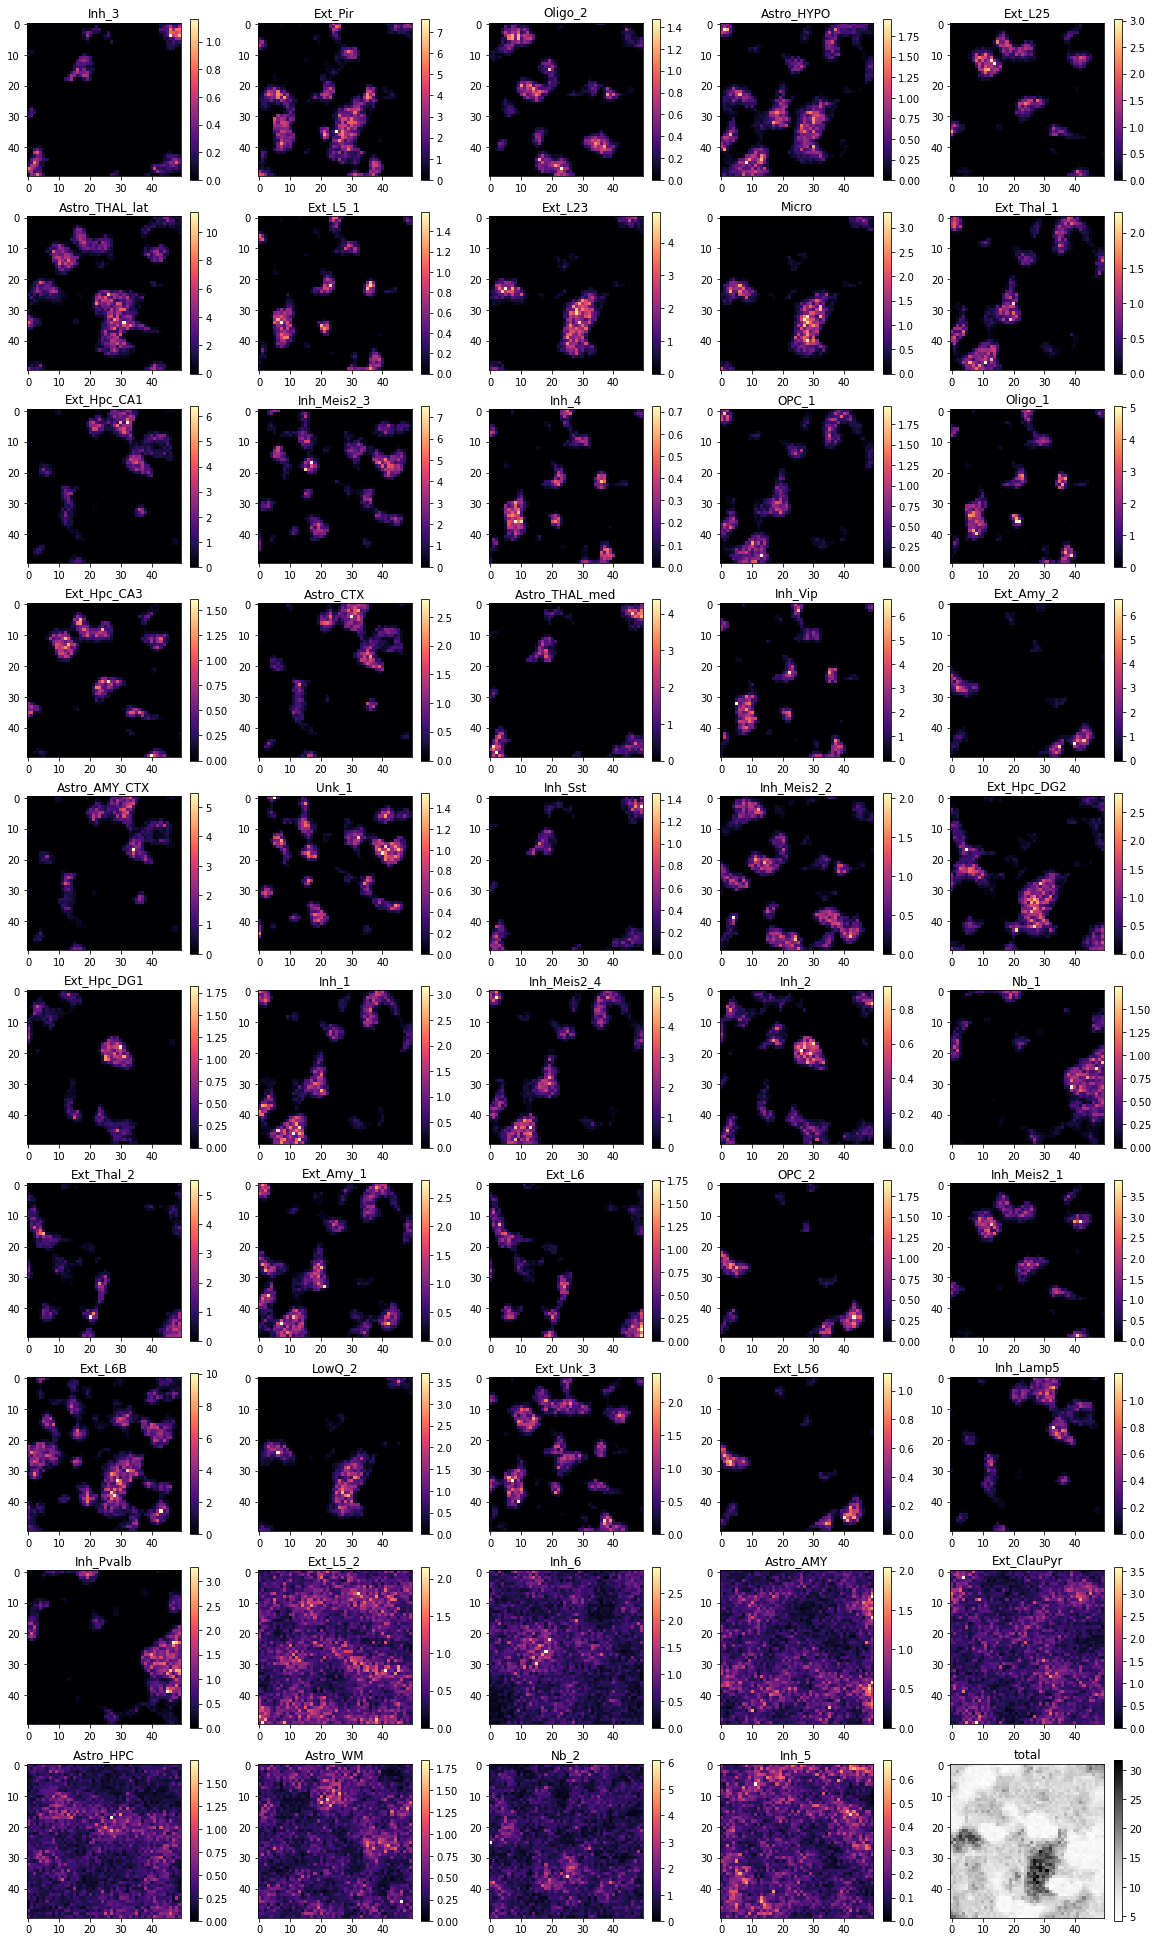

In [15]:
np.random.seed(seed)
cell_abundances = np.dot(abundances_df, cell_types2zones.T)
cell_abundances = cell_abundances * np.random.lognormal(0, 0.35, size=cell_abundances.shape)
cell_abundances_df = pd.DataFrame(cell_abundances, 
                             index=abundances_df.index,
                             columns=cell_types2zones.index
                            )

plt.figure(figsize=(3*5+5, 3*10+5))
plot_spatial(cell_abundances_df.values[experiment_id==0,:], 
             n=n_locations, nrows=10, 
             names=cell_abundances_df.columns, vmax=None)
plt.show()
plt.figure(figsize=(3*5+5, 3*10+5))
plot_spatial(cell_abundances_df.values[experiment_id==1,:], 
             n=n_locations, nrows=10, 
             names=cell_abundances_df.columns, vmax=None)
plt.show()

0.8726401592226017

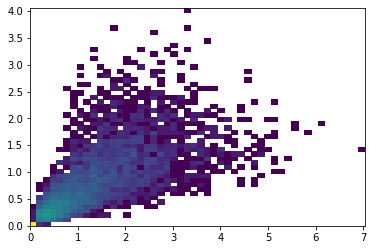

In [16]:
plt.hist2d(cell_abundances_df['Ext_L23'].values, 
           cell_abundances_df['Micro'].values,
           bins=50, norm=matplotlib.colors.LogNorm());
np.corrcoef(cell_abundances_df['Ext_L23'].values, 
            cell_abundances_df['Micro'].values)[0,1]

### Make cell abundance discrete

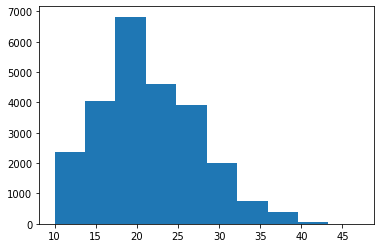

Inh_3              5302.0
Ext_Pir           17592.0
Oligo_2            4307.0
Astro_HYPO         8108.0
Ext_L25            5657.0
Astro_THAL_lat    23716.0
Ext_L5_1           4151.0
Ext_L23            7827.0
Micro              5950.0
Ext_Thal_1         4264.0
Ext_Hpc_CA1        7254.0
Inh_Meis2_3        9701.0
Inh_4              4031.0
OPC_1              4011.0
Oligo_1            6180.0
Ext_Hpc_CA3        4812.0
Astro_CTX          5332.0
Astro_THAL_med    10630.0
Inh_Vip            7381.0
Ext_Amy_2          7670.0
Astro_AMY_CTX      6467.0
Unk_1              5021.0
Inh_Sst            5482.0
Inh_Meis2_2        8053.0
Ext_Hpc_DG2       10277.0
Ext_Hpc_DG1        5102.0
Inh_1              4835.0
Inh_Meis2_4        5953.0
Inh_2              8977.0
Nb_1               5248.0
Ext_Thal_2         8188.0
Ext_Amy_1          8536.0
Ext_L6             5164.0
OPC_2              4501.0
Inh_Meis2_1        6077.0
Ext_L6B           28742.0
LowQ_2             5841.0
Ext_Unk_3          9036.0
Ext_L56     

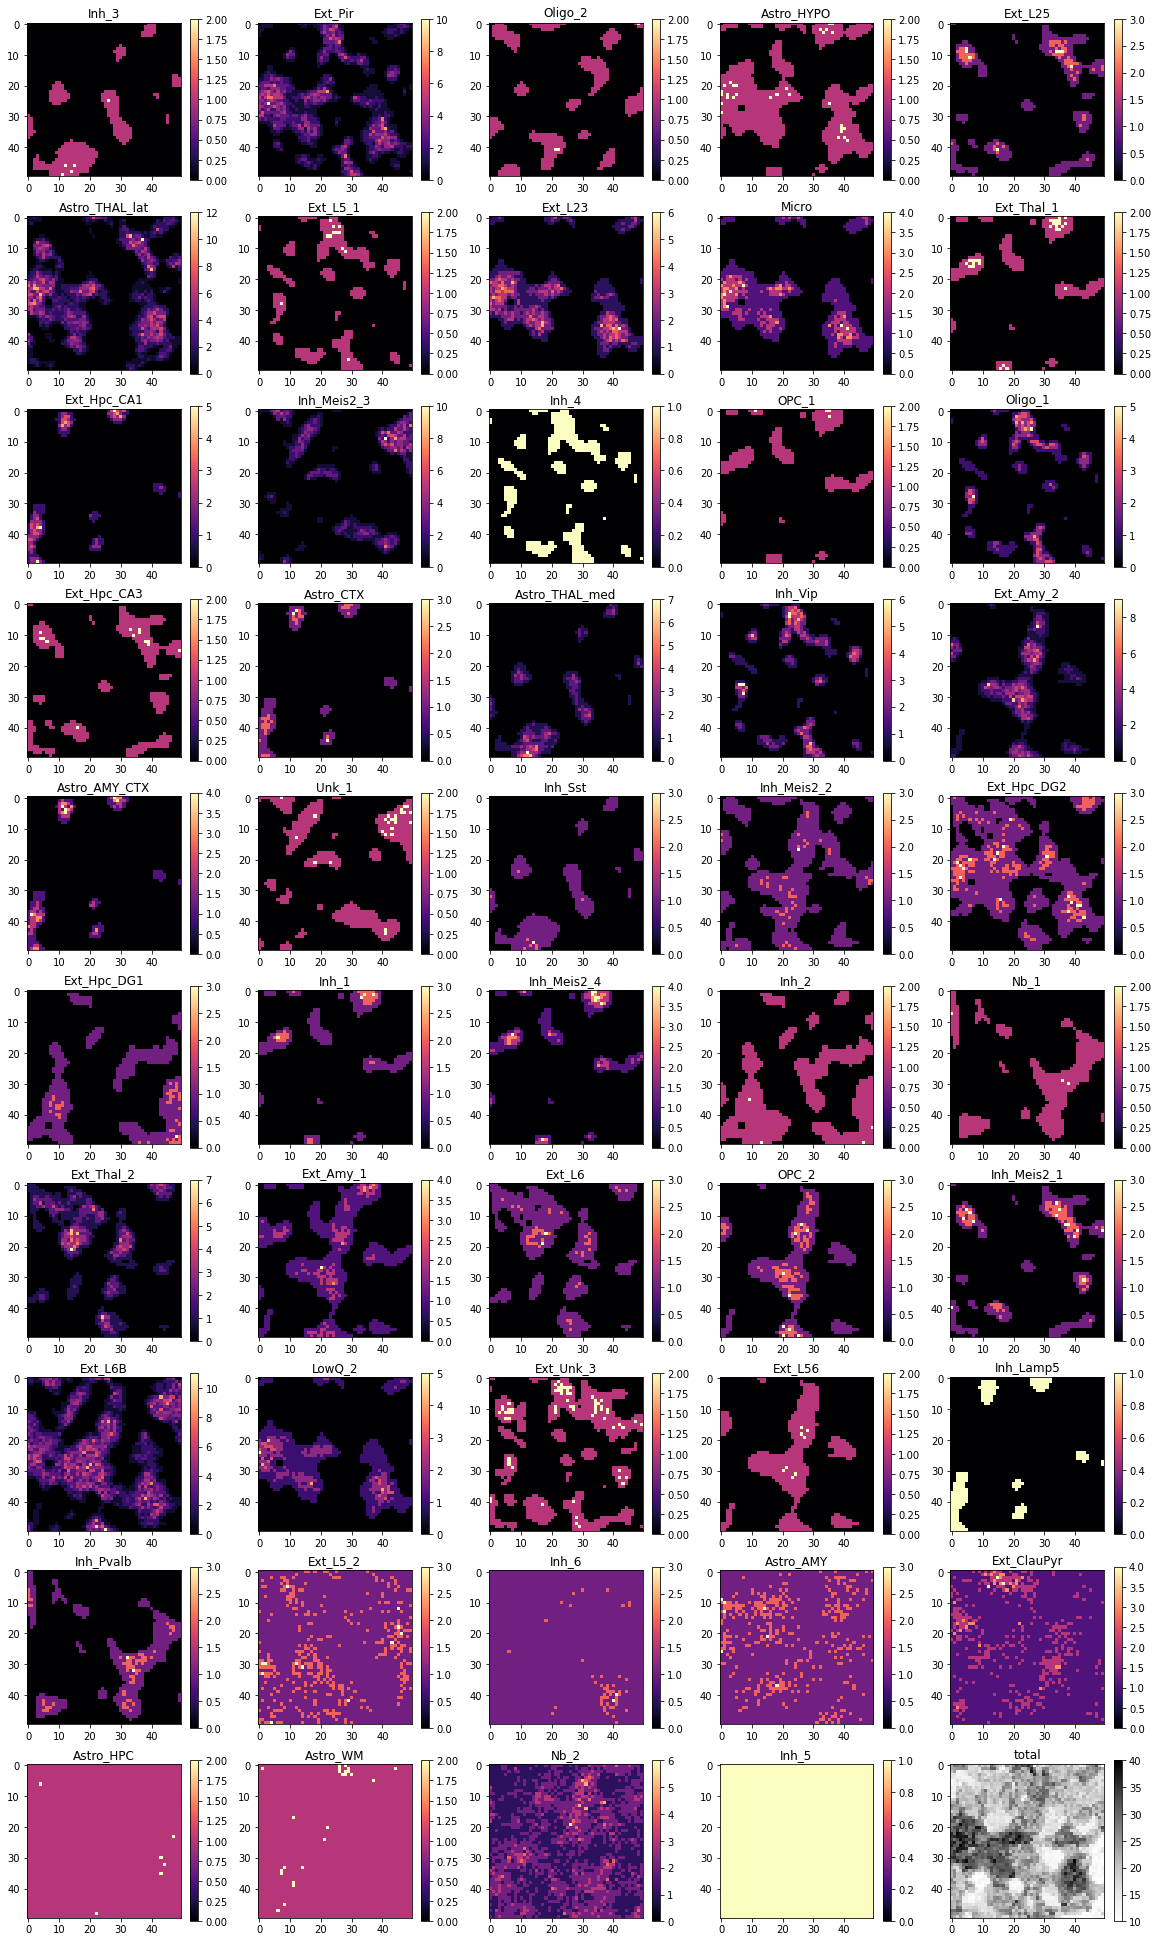

In [17]:
cell_count_df = np.ceil(cell_abundances_df)
plt.hist(cell_count_df.sum(1));
plt.show();

plt.figure(figsize=(3*5+5, 3*10+5))
plot_spatial(cell_count_df.values[experiment_id==0,:], 
             n=n_locations, nrows=10, 
             names=cell_count_df.columns, vmax=None)

cell_count_df.sum(0)

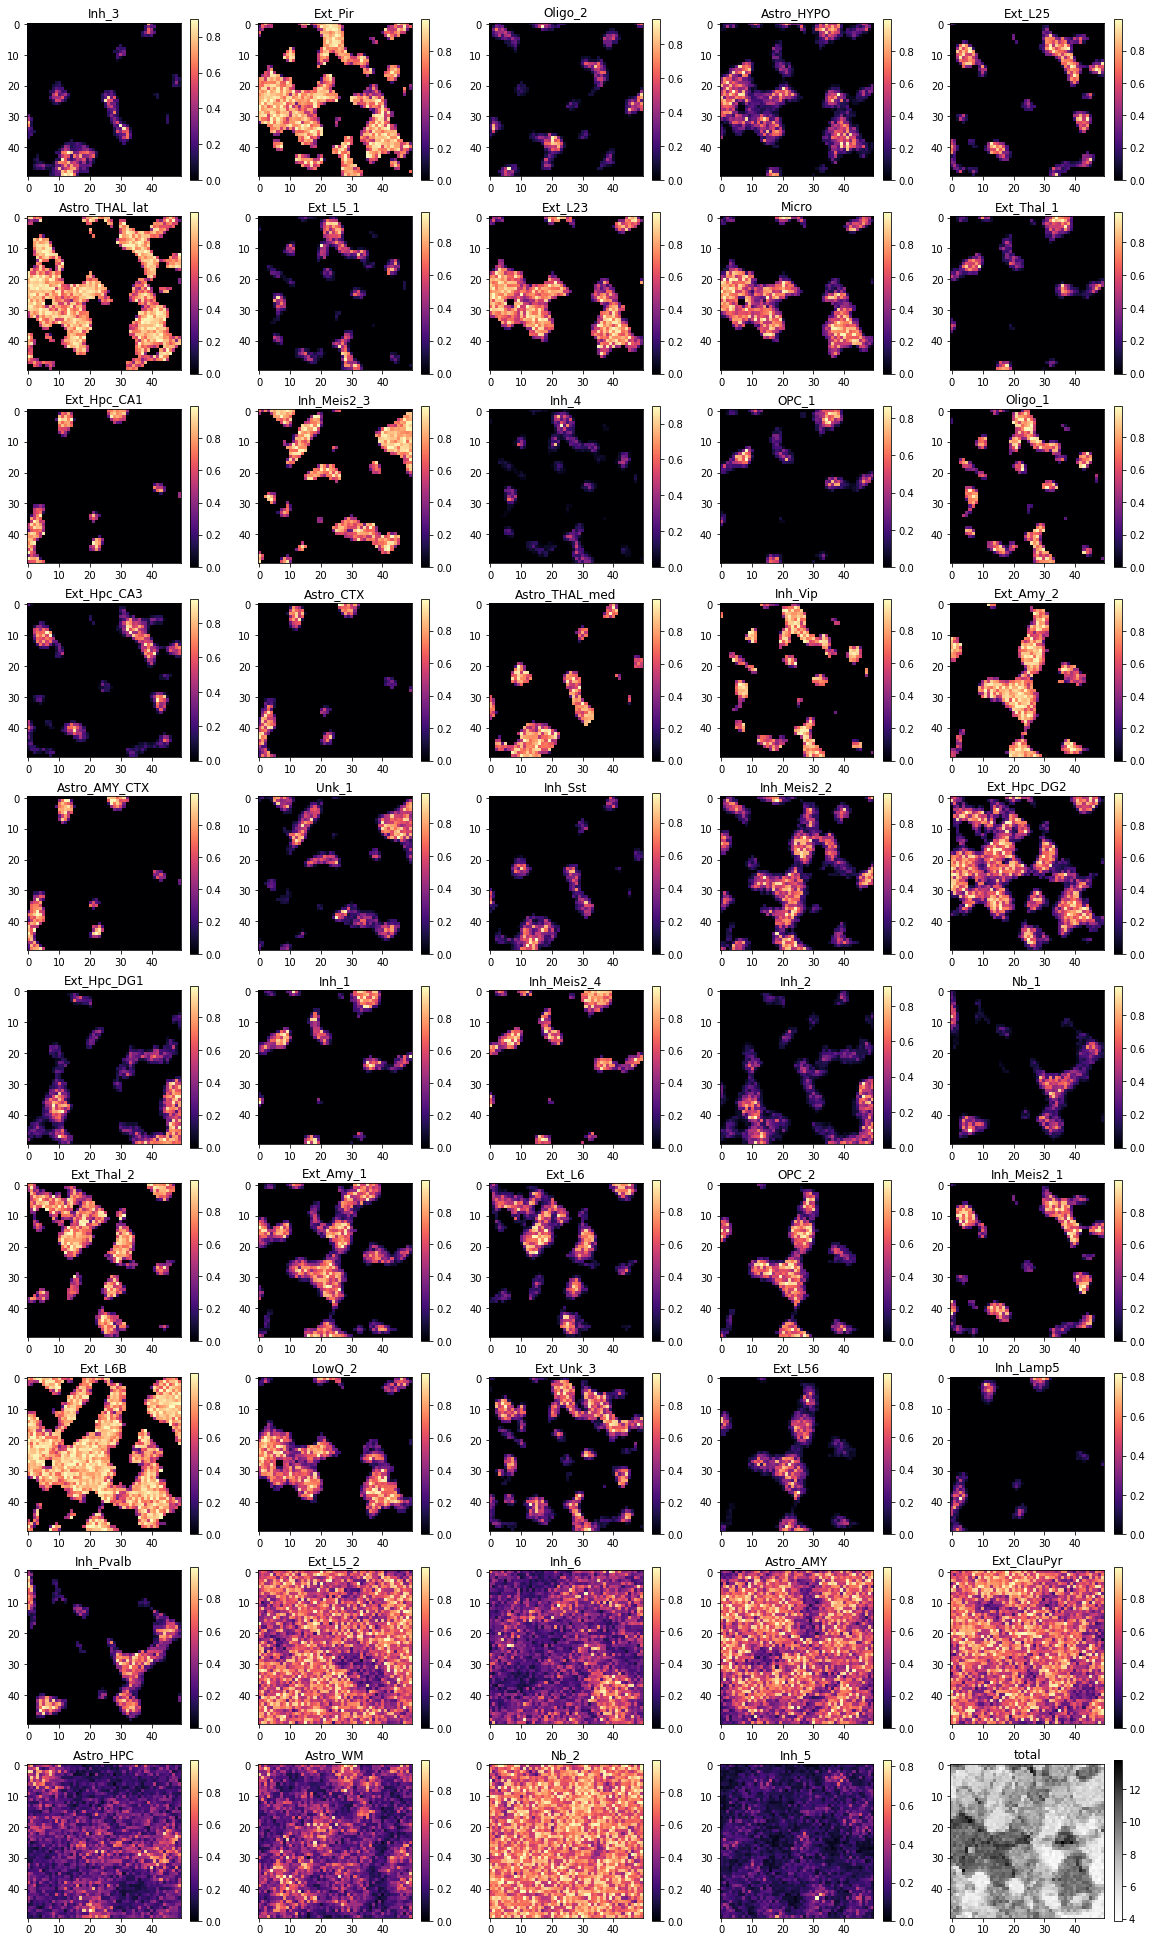

In [18]:
cell_capture_eff_df = cell_abundances_df / cell_count_df
cell_capture_eff_df[cell_capture_eff_df.isna()] = 0

plt.figure(figsize=(3*5+5, 3*10+5))
plot_spatial(cell_capture_eff_df.values[experiment_id==0,:], 
             n=n_locations, nrows=10, 
             names=cell_capture_eff_df.columns, vmax=None)

### Save resulting w_sf matrices

In [19]:
cell_count_df.to_csv(f'{sp_data_folder}cell_count_df_{date}.csv')
cell_capture_eff_df.to_csv(f'{sp_data_folder}cell_capture_eff_df_{date}.csv')
cell_abundances_df.to_csv(f'{sp_data_folder}cell_abundances_df_{date}.csv')

In [20]:
gp_bw = pd.DataFrame(np.concatenate((tissue_zones_l1_true, uniform_cell_types_l1_true)),
                     index=cell_types2zones.columns, columns=['GP_bandwidth'])
gp_bw.to_csv(f'{sp_data_folder}gp_bw_{date}.csv')

cell_types2zones['is_uniform'] = 0
cell_types2zones['is_uniform'][uniform_cell_types] = 1
cell_types2zones['is_high_density'] = 0
cell_types2zones['is_high_density'][high_density_cell_types] = 1
cell_types2zones.to_csv(f'{sp_data_folder}cell_types2zones_{date}.csv')

### Sample cell indices

In [21]:
cell_count_df

,Inh_3,Ext_Pir,Oligo_2,Astro_HYPO,Ext_L25,Astro_THAL_lat,Ext_L5_1,Ext_L23,Micro,Ext_Thal_1,...,Inh_Lamp5,Inh_Pvalb,Ext_L5_2,Inh_6,Astro_AMY,Ext_ClauPyr,Astro_HPC,Astro_WM,Nb_2,Inh_5
exper0_location_0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
exper0_location_1,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
exper0_location_2,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
exper0_location_3,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
exper0_location_4,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
exper9_location_2495,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,2.0,1.0
exper9_location_2496,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0
exper9_location_2497,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,1.0,2.0,2.0,1.0,1.0,2.0,1.0
exper9_location_2498,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,1.0,2.0,2.0,1.0,1.0,2.0,1.0


In [34]:
np.random.seed(seed)

from scipy.sparse import csr_matrix

# create generation set
generation_snrna = adata_snrna_raw[train_idx].copy()
# add index to each cell
generation_snrna.obs['cell_ind'] = np.arange(generation_snrna.shape[0])

def sample_cell_indices(generation_snrna, cell_count_df, cell_capture_eff_df):
    from scipy.sparse import csr_matrix
    locations2cells = np.zeros((cell_count_df.shape[0], generation_snrna.shape[0]))
    for i, l in enumerate(cell_count_df.index):
        for j, ct in enumerate(cell_count_df.columns):
            cell_ind_all = generation_snrna.obs['cell_ind']
            cell_ind_all = cell_ind_all[generation_snrna.obs['annotation_1'] == ct]
            cell_ind = np.random.choice(cell_ind_all, int(cell_count_df.loc[l, ct]), replace=False)
            locations2cells[i,cell_ind] = cell_capture_eff_df.loc[l, ct]

    return csr_matrix(locations2cells)
    
locations2cells = sample_cell_indices(generation_snrna, cell_count_df, cell_capture_eff_df)

### Construct mRNA counts, rescale sensitivity, add noise

In [35]:
# Compute synthetic counts
synthetic_counts = locations2cells.dot(generation_snrna.X)

# Create adata object
synth_adata = anndata.AnnData(synthetic_counts)
synth_adata.obs_names = cell_count_df.index
synth_adata.var_names = generation_snrna.var_names
synth_adata.obs[[f'cell_count_{ct}' for ct in cell_count_df.columns]] = cell_count_df
synth_adata.obs[[f'cell_abundances_{ct}' for ct in cell_abundances_df.columns]] = cell_abundances_df
synth_adata.obs[[f'cell_capture_eff_{ct}' for ct in cell_capture_eff_df.columns]] = cell_capture_eff_df
synth_adata.obsm['X_spatial'] = locations
synth_adata.uns['design'] = {'cell_types2zones': cell_types2zones,
                             'gp_bw': gp_bw}
from re import sub
synth_adata.obs['sample'] = [sub('_location.+$','',i) for i in synth_adata.obs_names]

synth_adata.shape

(25000, 31053)

In [36]:
# compute synthetic counts per cell type
for j, ct in enumerate(cell_count_df.columns):
    locations2cells_ct = sample_cell_indices(generation_snrna, cell_count_df[[ct]], cell_capture_eff_df)
    synthetic_counts_ct = locations2cells_ct.dot(generation_snrna.X)
    synth_adata.obs[f'UMI_count_{ct}'] = np.array(synthetic_counts_ct.sum(1)).flatten()

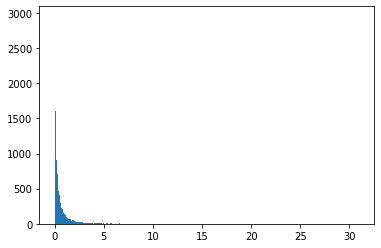

... storing 'sample' as categorical


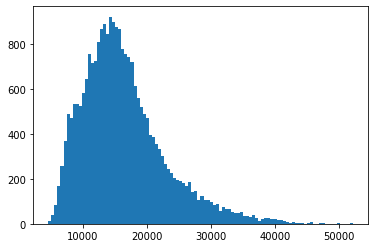

In [37]:
np.random.seed(seed)
# Use observed detection rates
synth_adata_obs_mg = synth_adata[:,gene_level_df.index].copy()
plt.hist(gene_level_df.values.flatten(), bins=500);
plt.show()

synth_adata_obs_mg.var['gene_level'] = gene_level_df.values.flatten()
synth_adata_obs_mg.X = synth_adata_obs_mg.X.toarray() * gene_level_df.values.T

# Sample poisson integers
synth_adata_obs_mg.layers['expression_levels'] = synth_adata_obs_mg.X
synth_adata_obs_mg.X = csr_matrix(np.random.poisson(synth_adata_obs_mg.X))
gene_level_df.values.mean()

# save resulting anndata
synth_adata_obs_mg.write(f'{sp_data_folder}synth_adata_real_mg_{date}.h5ad')

plt.hist(np.array(synth_adata_obs_mg.X.sum(1)).flatten(), bins=100);
plt.show()

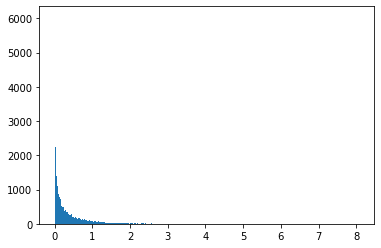

... storing 'sample' as categorical


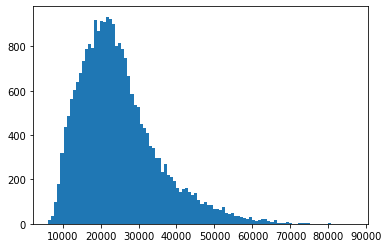

In [38]:
np.random.seed(seed)
# Sample detection rates
gene_level = np.random.gamma(shape=posterior['gene_level_alpha_hyp'].mean(), 
                             scale=1/posterior['gene_level_beta_hyp'].mean(), 
                             size=(1, synth_adata.shape[1])) / 2
plt.hist(gene_level.flatten(), bins=500);
plt.show()

synth_adata.var['gene_level'] = gene_level.flatten()
synth_adata.X = synth_adata.X.toarray() * gene_level

# Sample poisson integers
synth_adata.layers['expression_levels'] = synth_adata.X
synth_adata.X = np.random.poisson(synth_adata.X)
synth_adata.X = csr_matrix(synth_adata.X)
gene_level.mean()

# save resulting anndata
synth_adata.write(f'{sp_data_folder}synth_adata_random_mg_{date}.h5ad')

plt.hist(np.array(synth_adata.X.sum(1)).flatten(), bins=100);
plt.show()

## Add contamination to each synthetic experiment

In [39]:
np.random.seed(seed)

synth_adata_contam = synth_adata.copy()

# sample contamination
contamination_average = synth_adata.X.mean(0)

mu_contamination = 0.03
mean_var_ratio=150
per_experiment_proportion = np.random.gamma(mu_contamination * mean_var_ratio, 
                                            1/mean_var_ratio, 
                                            size=(n_experiments, 1))

average_contamination = per_experiment_proportion * contamination_average
cell2sample_df = pd.get_dummies(synth_adata.obs['sample'])
per_loc_average_contamination = np.dot(cell2sample_df.values, average_contamination)

# add contamination counts
contamination = csr_matrix(np.random.poisson(per_loc_average_contamination))
synth_adata_contam.layers['contamination'] = contamination
synth_adata_contam.X = synth_adata_contam.X + contamination

# save resulting anndata
synth_adata_contam.write(f'{sp_data_folder}synth_adata_contamination_{date}.h5ad')

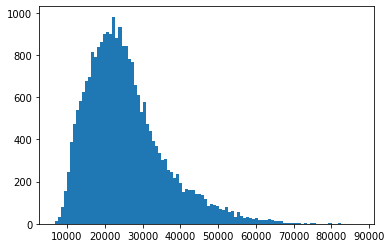

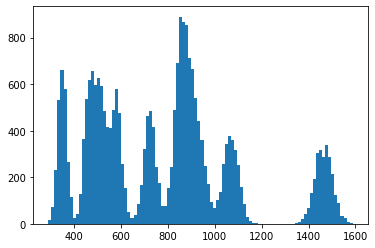

In [40]:
plt.hist(np.array(synth_adata_contam.X.sum(1)).flatten(), bins=100);
plt.show();
plt.hist(np.array(synth_adata_contam.layers['contamination'].sum(1)).flatten(), bins=100);
plt.show();

## Add contamination and sequencing depth each synthetic experiment

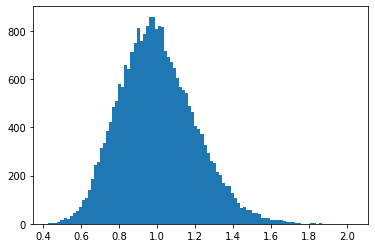

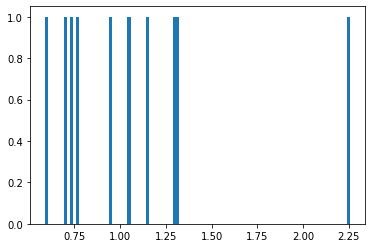

In [41]:
np.random.seed(seed)

synth_adata_contam_depth = synth_adata.copy()

# sample contamination
contamination_average = synth_adata.X.mean(0)

mu_contamination = 0.03
mean_var_ratio=150
per_experiment_proportion = np.random.gamma(mu_contamination * mean_var_ratio, 
                                            1/mean_var_ratio, 
                                            size=(n_experiments, 1))

average_contamination = per_experiment_proportion * contamination_average
cell2sample_df = pd.get_dummies(synth_adata.obs['sample'])
per_loc_average_contamination = np.dot(cell2sample_df.values, average_contamination)

# samples per-location variability in sequencing depth
mu_depth = 1
mean_var_ratio=25
per_location_depth = np.random.gamma(mu_depth * mean_var_ratio, 
                                            1/mean_var_ratio, 
                                            size=(synth_adata.shape[0], 1))
plt.hist(np.array(per_location_depth).flatten(), bins=100);
plt.show()

# sample per-experiment variability in sequencing depth
mu_depth = 1
mean_var_ratio=5
per_experiment_depth = np.random.gamma(mu_depth * mean_var_ratio, 
                                            1/mean_var_ratio, 
                                            size=(n_experiments, 1))
plt.hist(np.array(per_experiment_depth).flatten(), bins=100);
plt.show()

# generate total sequencing depth effect
per_location_depth_total = per_location_depth * np.dot(cell2sample_df.values, per_experiment_depth)
synth_adata_contam_depth.obs['per_location_depth_total'] = np.array(per_location_depth_total).flatten()
synth_adata_contam_depth.obs['per_location_depth'] = np.array(per_location_depth).flatten()
synth_adata_contam_depth.obs['per_experiment_depth'] = np.array(np.dot(cell2sample_df.values,
                                                                       per_experiment_depth)).flatten()

# add sequencing depth effect
synth_adata_contam_depth.layers['expression_levels_depth'] \
= synth_adata_contam_depth.layers['expression_levels'] * per_location_depth_total
synth_adata_contam_depth.X = csr_matrix(np.random.poisson(synth_adata_contam_depth.layers['expression_levels_depth']))

# add contamination counts
contamination = csr_matrix(np.random.poisson(np.array(per_loc_average_contamination) * per_location_depth_total))
synth_adata_contam_depth.layers['contamination'] = contamination
synth_adata_contam_depth.X = synth_adata_contam_depth.X + contamination

# save resulting anndata
synth_adata_contam_depth.write(f'{sp_data_folder}synth_adata_contamination_depth_{date}.h5ad')

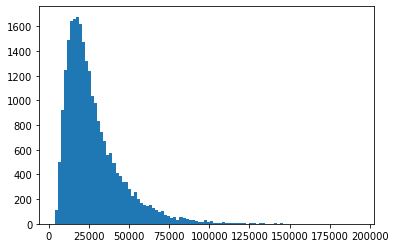

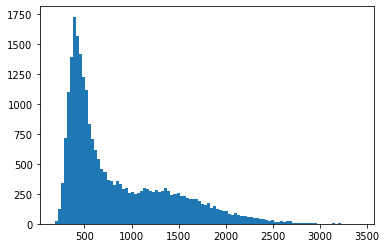

In [42]:
plt.hist(np.array(synth_adata_contam_depth.X.sum(1)).flatten(), bins=100);
plt.show();
plt.hist(np.array(synth_adata_contam_depth.layers['contamination'].sum(1)).flatten(), bins=100);
plt.show();

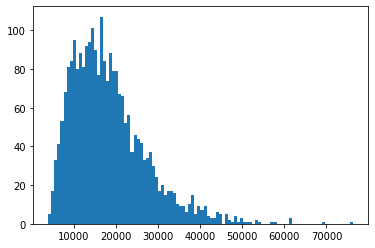

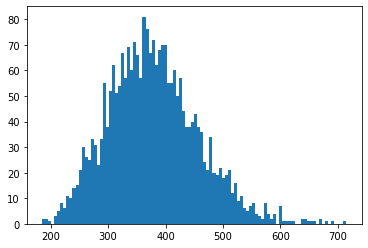

In [43]:
plt.hist(np.array(synth_adata_contam_depth[synth_adata_contam_depth.obs['sample'] == 'exper1',:].X.sum(1)).flatten(), bins=100);
plt.show();
plt.hist(np.array(synth_adata_contam_depth[synth_adata_contam_depth.obs['sample'] == 'exper1',:].layers['contamination'].sum(1)).flatten(), bins=100);
plt.show();